## Elementos finitos linear 1D

## Montar a matrix de massa

In [1]:
using Jacobi

## Funções

In [2]:
remap(x,a,b) = ((1-x)*a + (1+x)*b)/2

remap (generic function with 1 method)

In [3]:
function ψj(p,E,Q)
    if(p == 1)
     return  (1-E)/2
        elseif(p == 2)
     return  (1+E)/2
    else
     return  (1-E)*(1+E)/4 .* jacobi(E, p-3, 1, 1)
    end
end 

ψj (generic function with 1 method)

In [4]:
function  ϕ_matrix(ψj,Q,M)
    ϕ = zeros(Q,M)
    ξ = zglj(Q)
    for i in 1:M
        for j in 1:Q
            ϕ[j,i] = ψj(i,ξ[j],M)
        end
    end
  return ϕ
end

ϕ_matrix (generic function with 1 method)

In [5]:
function  ϕ_matrix_interp(ψj,Q,M)
    ϕ = zeros(Q,M)
    ξ = linspace(-1,1,Q)
    for i in 1:M
        for j in 1:Q
            ϕ[j,i] = ψj(i,ξ[j],M)
        end
    end
  return ϕ
end

ϕ_matrix_interp (generic function with 1 method)

In [31]:
function Me_matrix(ϕ,w,M,Q,a,b)
    L = zeros(M,M)
    jac = (b-a)/2
    for i in 1:M
        for j in 1:M
           m= 0.0
            for q in 1:Q
                m = m + ϕ[q,i]*ϕ[q,j]*w[q]*jac
            end
            L[i,j] = m
        end
    end
    return L
end

Me_matrix (generic function with 1 method)

1.0

### $ϕ$ e  matriz de massa

In [7]:
Nel = 5
I = 5
nb = Nel + 1
ni = (I-2)
Q = I+2

#indices locais
ib = collect(1:2)
ii = collect(3:I)

#limites
a = -1; 
b = 1;

z = zglj(Q)
w = wglj(z)
ϕ = ϕ_matrix(ψj,Q,I);
xn = [linspace(a,b,Nel+1);];
X = zeros(Q,Nel)
remap(x,a,b) = ((1-x)*a + (1+x)*b)/2
for e in 1:Nel
    X[:,e] = [remap(x,xn[e],xn[e+1]) for x in z]
end
X

7x5 Array{Float64,2}:
 -1.0       -0.6       -0.2        0.2       0.6     
 -0.966045  -0.566045  -0.166045   0.233955  0.633955
 -0.89377   -0.49377   -0.0937698  0.30623   0.70623 
 -0.8       -0.4        0.0        0.4       0.8     
 -0.70623   -0.30623    0.0937698  0.49377   0.89377 
 -0.633955  -0.233955   0.166045   0.566045  0.966045
 -0.6       -0.2        0.2        0.6       1.0     

In [8]:

dof_map = zeros(Int, 2, Nel)
for i = 1:Nel
    dof_map[1,i] = i
    dof_map[2,i] = i+1
end
dof_map

2x5 Array{Int64,2}:
 1  2  3  4  5
 2  3  4  5  6

In [9]:

using Base.LinAlg.BLAS.gemm!
using Base.LinAlg.BLAS.gemv!
using Base.LinAlg.LAPACK.potrf!
using Base.LinAlg.LAPACK.potrs!

### $ A_{bb}^* = (A_{bb} - A_{bi} A_{ii}^{-1} A_{ib})  $

In [33]:
Abb = zeros(Nel+1,Nel+1)
M = Vector{Array{Float64,2}}(Nel)
Mii = Vector{Array{Float64,2}}(Nel)
for e in 1:Nel
    Me  = Me_matrix(ϕ,w,I,Q,a,b)
    Mbb = Me[ib,ib]
    Mbi = Me[ib,ii]
    Mib = Me[ii,ib]
    Mii[e] = Me[ii,ii]
    
    potrf!('L',Mii[e]); #Mii^-1
    M[e] = copy(Mib)
    potrs!('L',Mii[e],M[e]) # M = Mii^-1 * Mbi
    gemm!('T', 'N', -1.0, M[e], Mib, 1.0, Mbb) # Mbb = -1*M*Mib + Mbb
    
    for i in 1:2
        ig = dof_map[i,e]
        for j in 1:2
            jg = dof_map[j,e]
            Abb[ig,jg] += Mbb[i,j]
        end
    end
end

potrf!('L',Abb);


In [11]:
Abb

6x6 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

## RHS

In [12]:
fun(x) = cos(2*pi*x)
#calcula F
Fe = zeros(I,Nel)
for e = 1:Nel
    jac = (xn[e+1] - xn[e] )/2
    for i in 1:I
        temp = 0.0
        for q in 1:Q
            temp += fun(X[q,e])* ϕ[q,i] * w[q] * jac
        end
        Fe[i,e] = temp
    end
end
Fe

5x5 Array{Float64,2}:
  0.114557    -0.164349     0.151365     -0.080565    -0.0210084 
 -0.0210084   -0.080565     0.151365     -0.164349     0.114557  
  0.0175261   -0.045884     0.0567158    -0.045884     0.0175261 
 -0.0284294    0.0175703    8.67362e-19  -0.0175703    0.0284294 
 -0.00255244   0.00668237  -0.00825986    0.00668237  -0.00255244

In [13]:
B = Fe[:,1]
Bb = B[ib]
Bi = B[ii];

### $f_b^* =f_b - A_{bi} A_{ii}^{-1} f_i$

In [14]:
Fb = zeros(nb)

for e in 1:Nel
    fe  = Fe[:,e]
    fb  = fe[ib]
    fi  = fe[ii]
    gemv!('T',-1.0,M[e],fi, 1.0, fb) #fbb = -1*M^T*fi + fb

    for i in 1:2
        ig = dof_map[i,e]
        Fb[ig] += fb[i]
    end
end
Fb

LoadError: LoadError: UndefRefError: access to undefined reference
while loading In[14], in expression starting on line 3

# Solve   $A^*_{bb}\ u_b =\ f^*_b$

In [15]:
Abb

6x6 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

In [16]:
potrs!('L',Abb,Fb)
Ub = Fb


6-element Array{Float64,1}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

### $u_i = A_{ii}^{-1}f_i - A_{ii}^{-1} A_{bi}^t u_b$

In [17]:
U = zeros(I,Nel)
for e in 1:Nel
    ub  = Ub[vec(dof_map[:,e])]
    fe  = Fe[:,e]
    fi  = fe[ii]

    potrs!('L',Mii[e],fi)
    gemv!('N',-1.0,M[e],ub,1.0,fi) #fi = -1*M*ub + fi
    
    U[ib,e] = ub
    U[ii,e] = fi
end
U

LoadError: LoadError: UndefRefError: access to undefined reference
while loading In[17], in expression starting on line 2

In [18]:
Uh = zeros(Q,Nel)
for e in 1:Nel
    Uh[:,e] = ϕ*U[:,e]
end
Uh

7x5 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

In [19]:
using PyPlot

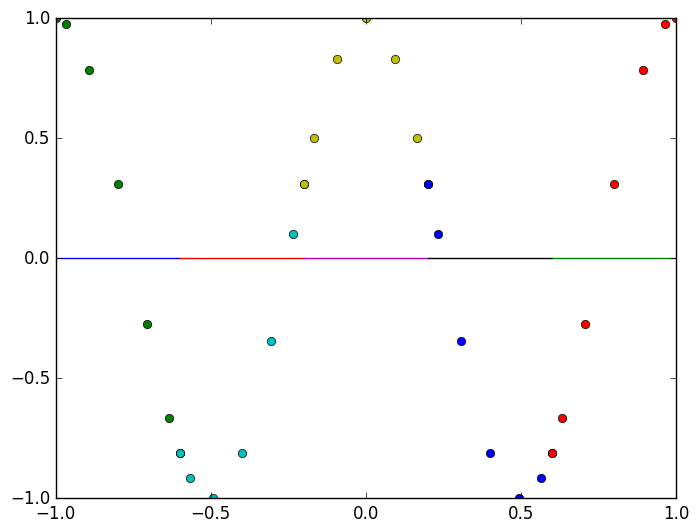

In [20]:
for e in 1:Nel
    plot(X[:,e],Uh[:,e])
    plot(X[:,e],fun(X[:,e]),"o")
#    legend()
end
